<a href="https://colab.research.google.com/github/fyaish/fbprophet/blob/master/Traffic_Forecasting_with_Scout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traffic Forecasting with Scout

Forecast traffic (including seasonality) to your web app! Just enter your [Scout](https://scoutapp.com) API `TOKEN` below.

# Scout API Setup

In [0]:
# API DOCS: http://help.apm.scoutapp.com/#introduction
# Create your API key @ https://apm.scoutapp.com/settings
TOKEN = "CHANGE ME!!!"
APP_ID = 0 # The ID of the app you wish to forecast (grap from your URL bar - ie https://apm.scoutapp.com/apps/APP_ID)

# Setup

In [0]:
# Otherwise lots of noisy output
import warnings
warnings.filterwarnings('ignore')

# Common libs
import pandas as pd
import json
import os
import numpy as np
from datetime import datetime, date, timedelta
import math

# View more columns in output of Panda Dataframes
pd.set_option('display.max_columns', 500)

# Setup Matlab for plotting
%matplotlib inline
import *
import matplotlib.pyplot as plt

# Timeseries
from fbprophet import Prophet

from pandas.plotting import scatter_matrix
import requests

# Set the header for requests sent to the Scout API
HEADERS = {"X-SCOUT-API": TOKEN}

# Fetch Time Series Data

In [0]:
METRIC = 'throughput' # in requests per-minute
url = "https://apm.scoutapp.com/api/v0/apps/{app_id}/metrics/throughput".format(app_id=APP_ID)

today = datetime.now()

# The API has a max timeframe of 2 weeks but 30 days of data is stored. We'll
# fetch 4 works of data by making two requests.
range = [(today - timedelta(days=14)),today]

raw_ts = []

for end_time in range:

    params = {
        "from": (end_time - timedelta(days=14)).isoformat(),
        "to": end_time.isoformat()
    }

    r = requests.get(url, params=params, headers=HEADERS)
    if (r.status_code == 200):
      res=r.json()
      raw_ts += res["results"]['series'][METRIC]
    else:
      print("An error occurred contacting the Scout API. Status Code=",r.status_code)

An error occurred contacting the Scout API. Status Code= 403
An error occurred contacting the Scout API. Status Code= 403


In [0]:
print("Time Series Data Length:", len(raw_ts), "Time Range:", raw_ts[0][0], "-", raw_ts[-1][0])

Time Series Data Length: 338 Time Range: 2019-02-06T22:00:00Z - 2019-03-06T22:00:00Z


# Create a Dataframe

In [0]:
df = pd.DataFrame(raw_ts,columns=["time",METRIC],)
df.time = pd.to_datetime(df.time)
df = df.set_index("time")
df.tail()

,throughput
time,
2019-03-06 14:00:00,541.275000
2019-03-06 16:00:00,545.300000
2019-03-06 18:00:00,527.208333
2019-03-06 20:00:00,479.641667
2019-03-06 22:00:00,208.766667


# Plot Time Series

Text(0, 0.5, 'throughput')

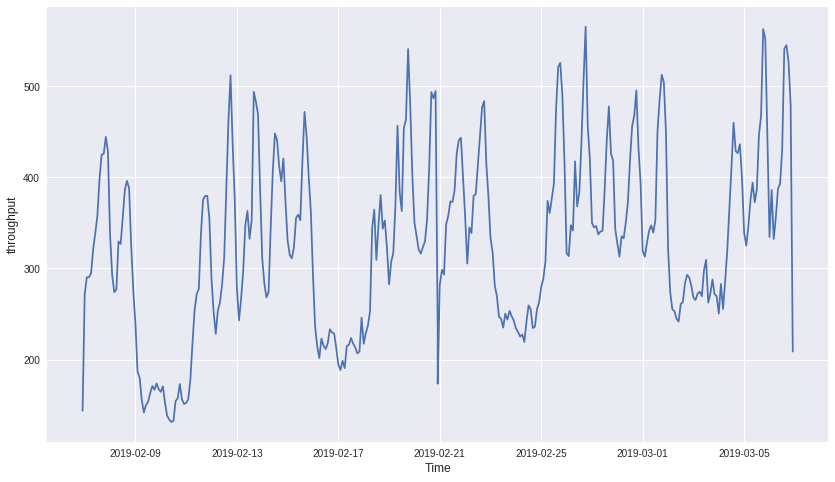

In [0]:
plt.figure(figsize=(14,8))
plt.plot(df.index.values, df[df.columns[0]].values)
plt.xlabel('Time', fontsize=12)
plt.ylabel(METRIC, fontsize=12)

# Remove outliers
Large drops are likely from deploys

In [0]:
df = df[df.throughput > df.throughput.quantile(0.0001)]

# Time Series Modeling with Prophet

In [0]:
model = Prophet()
df["time_for_prophet"] = df.index # hack ... can't use index
model.fit(df.rename_axis("ds").rename(columns={"time_for_prophet": "ds",METRIC: "y"}))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [0]:
df_forecast = model.make_future_dataframe(periods=14, freq="D")
forecast = model.predict(df_forecast)

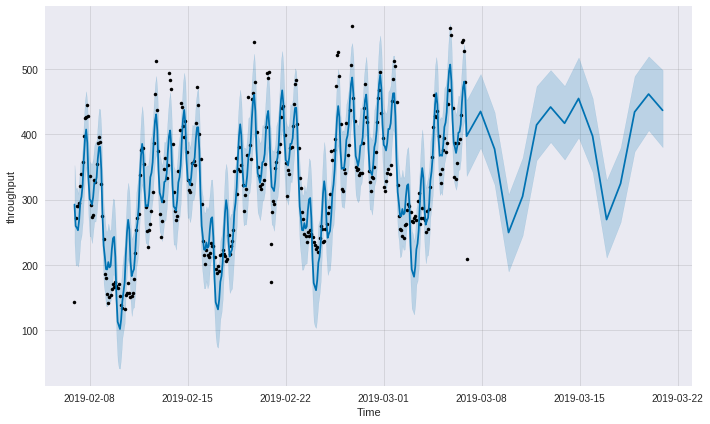

In [0]:
# ; - prevents duplicates: https://github.com/facebook/prophet/issues/124#issuecomment-288693888
model.plot(forecast, xlabel="Time", ylabel=METRIC);

# Trend Visualization

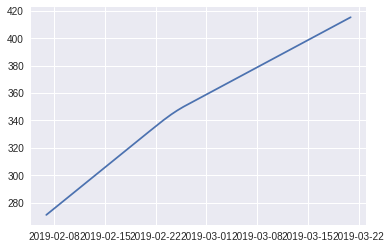

In [0]:
plt.plot(forecast.ds, forecast.trend)

# Plot model components

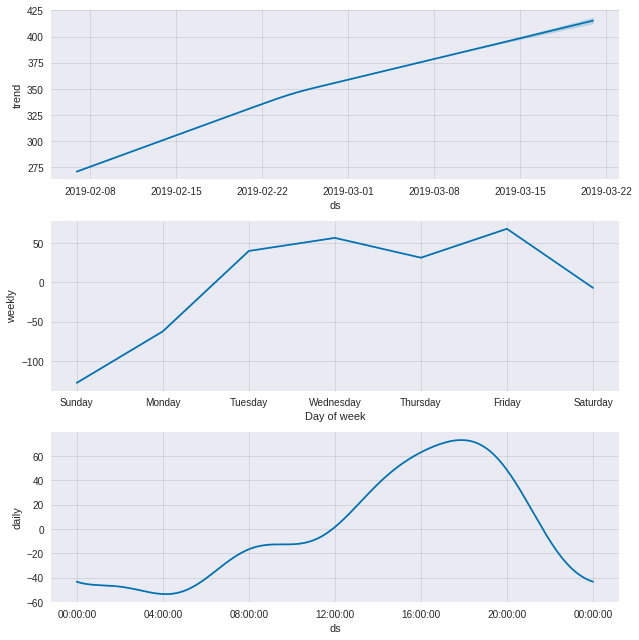

In [0]:
model.plot_components(forecast);